In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from enum import IntEnum

# prefix = "AMZN_2012-06-21_34200000_57600000"
prefix = "INTC_2012-06-21_34200000_57600000"

trades_data_file = f"./data/{prefix}_message_5.csv"
orderbook_data_file = f"./data/{prefix}_orderbook_5.csv"

trade_df = pd.read_csv(trades_data_file, names=(
    'time',
    'type',
    'orderId',
    'size',
    'price',
    'direction'
))

orderbook_df = pd.read_csv(orderbook_data_file, names=(
    'ask1_price',
    'ask1_size',
    'bid1_price',
    'bid1_size',

    'ask2_price',
    'ask2_size',
    'bid2_price',
    'bid2_size',

    'ask3_price',
    'ask3_size',
    'bid3_price',
    'bid3_size',

    'ask4_price',
    'ask4_size',
    'bid4_price',
    'bid4_size',

    'ask5_price',
    'ask5_size',
    'bid5_price',
    'bid5_size',
))

df = pd.concat([trade_df, orderbook_df], axis=1)
df['event_lapse'] = df['time'].diff().fillna(0)

In [14]:
tick_size = 100

midprice = (df['bid1_price'] + df["ask1_price"]) / 2
midpricePlusTick = midprice + tick_size / 2
midpriceSubTick = midprice - tick_size / 2
spread = df["ask1_price"] - df['bid1_price']

conditions = [
    spread == tick_size,
    df["ask1_price"] >= df['bid1_price'],
    df["ask1_price"] < df['bid1_price']
]

choices = [
    midprice,
    midpricePlusTick,
    midpriceSubTick
]

df['reference_price'] = np.select(conditions, choices)

for n in range(0, 3):
    bid_price_level = df['reference_price'] - (tick_size / 2) - (tick_size * n)
    ask_price_level = df['reference_price'] + (tick_size / 2) + (tick_size * n)

    bid_conditions = [
        bid_price_level == df['bid1_price'],
        bid_price_level == df['bid2_price'],
        bid_price_level == df['bid3_price'],
        bid_price_level == df['bid4_price'],
        bid_price_level == df['bid5_price'],
    ]
    ask_conditions = [
        ask_price_level == df['ask1_price'],
        ask_price_level == df['ask2_price'],
        ask_price_level == df['ask3_price'],
        ask_price_level == df['ask4_price'],
        ask_price_level == df['ask5_price'],
    ]

    bid_choices = [
        df['bid1_size'].astype(float),
        df['bid2_size'].astype(float),
        df['bid3_size'].astype(float),
        df['bid4_size'].astype(float),
        df['bid5_size'].astype(float)
    ]
    ask_choices = [
        df['ask1_size'],
        df['ask2_size'],
        df['ask3_size'],
        df['ask4_size'],
        df['ask5_size']
    ]

    df[f'norm_bid{n + 1}_price'] = bid_price_level
    df[f'norm_ask{n + 1}_price'] = ask_price_level
    df[f'norm_bid{n + 1}_size'] = np.select(bid_conditions, bid_choices)
    df[f'norm_ask{n + 1}_size'] = np.select(ask_conditions, ask_choices)

# print(df['ask1_price'], df['bid1_price'], df['reference_price'])
# print(df)

In [17]:
DEPTH = 3
ORDER_TYPES = 3

NORMALIZED_QUEUE_MAX = 50

# Orderbook depth, ordertype (limit, market, cancelation), depth of queue storage we are tracking
lambdas = np.zeros((DEPTH, ORDER_TYPES, NORMALIZED_QUEUE_MAX))

event_in_queue = [
    (df['norm_bid1_price'] == df['price']) | (df['norm_ask1_price'] == df['price']),
    (df['norm_bid2_price'] == df['price']) | (df['norm_ask2_price'] == df['price']),
    (df['norm_bid3_price'] == df['price']) | (df['norm_ask3_price'] == df['price']),
]

average_event_size_per_queue = [
    df[event_in_queue[0]]['size'].mean(),
    df[event_in_queue[1]]['size'].mean(),
    df[event_in_queue[2]]['size'].mean()
]

for depth_level in range(0, DEPTH):
    df_at_depth = df.loc[event_in_queue[depth_level]]
    
    bid_queue_length = np.ceil(df_at_depth[f'norm_bid{depth_level + 1}_size'].astype(float) / average_event_size_per_queue[depth_level])
    ask_queue_length = np.ceil(df_at_depth[f'norm_ask{depth_level + 1}_size'].astype(float) / average_event_size_per_queue[depth_level])

    for queue_index in range(0, NORMALIZED_QUEUE_MAX):
        bidMatchesNormalizedQueue = (bid_queue_length == queue_index)
        askMatchesNormalizedQueue = (ask_queue_length == queue_index)
       
        matchesNormalizedQueue = (bidMatchesNormalizedQueue | askMatchesNormalizedQueue)

        df_at_queue = df_at_depth.loc[matchesNormalizedQueue]

        isLimitOrder = (df_at_queue['type'] == 1)
        isMarketOrder = (df_at_queue['type'] == 4) | (df_at_queue['type'] == 5)
        isCancelOrder = (df_at_queue['type'] == 2) | (df_at_queue['type'] == 3)

        dt_order = df_at_queue['time'].diff().fillna(0).mean()

        numb_orders_matching_norm_queue = len(df_at_queue)

        lambdas[depth_level, 0, queue_index] = len(df_at_queue[isLimitOrder]) / (numb_orders_matching_norm_queue * dt_order)
        lambdas[depth_level, 1, queue_index] = len(df_at_queue[isMarketOrder]) / (numb_orders_matching_norm_queue * dt_order)
        lambdas[depth_level, 2, queue_index] = len(df_at_queue[isCancelOrder]) / (numb_orders_matching_norm_queue * dt_order)
        
        # print(len(df_at_queue[isCancelOrder]), numb_orders_matching_norm_queue, dt_order)
    # print()

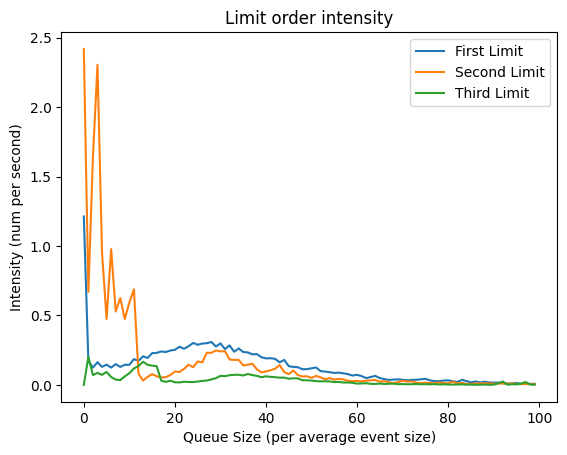

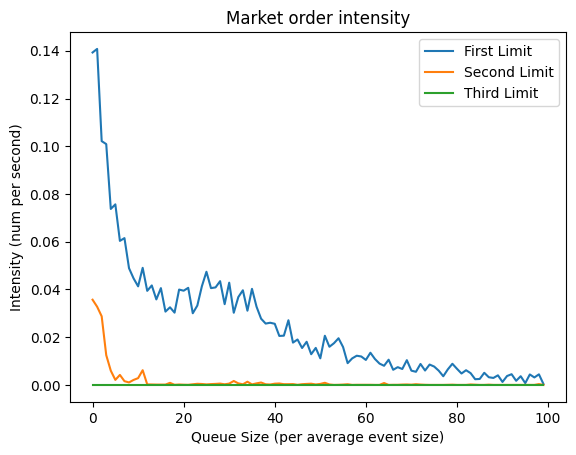

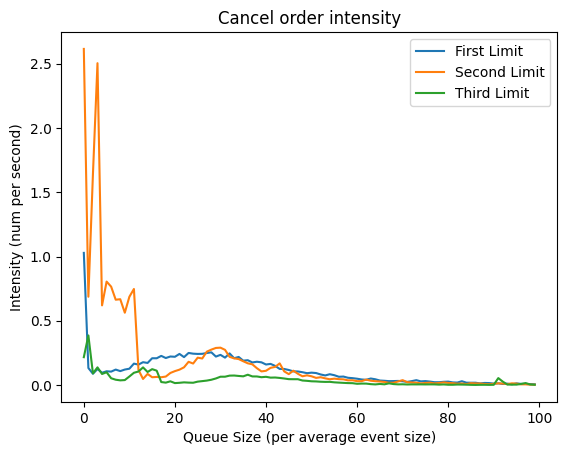

In [18]:
for i in range(0, ORDER_TYPES):
    lambdas[0][i][np.isnan(lambdas[0][i])] = 0
    lambdas[1][i][np.isnan(lambdas[1][i])] = 0
    lambdas[2][i][np.isnan(lambdas[2][i])] = 0
    plt.plot(lambdas[0][i], label="First Limit")

    plt.plot(lambdas[1][i], label="Second Limit")

    plt.plot(lambdas[2][i], label="Third Limit")

    plt.ylabel("Intensity (num per second)")

    plt.xlabel("Queue Size (per average event size)")

    plt.legend()
    if (i == 0):
        order_type = "Limit"
    elif (i == 1):
        order_type = "Market"
    else:
        order_type = "Cancel"

    plt.title(f"{order_type} order intensity")

    plt.show()